# Riset Konversi PDF ke Gambar

**Tujuan**
- Membandingkan kecepatan convert file pdf ke file gambar
- Menentukan library yang digunakan untuk konversi pdf menjadi gambar

**Parameter:**
- PDF Converter Libraries: {pdf2image, pdfium, pymupdf}
- DPI: {300, 250, 200, 150, 100, 50, 20, 10, 5, 1}
- Waktu Konversi
- Render Options: {}

**Base perbandingan:**
- Kualitas gambar 300 DPI
- Waktu konversi pdf untuk kualitas gambar 300 DPI

**CSV Column for Comparisons:**
- datetime
- library_name
- dpi
- converting_time
- output_folder_size

**Output**
- file `cmyk_by_dpi_and_library.csv`

In [16]:
import sys
import os
from pdf2image import convert_from_path
import pymupdf
import pypdfium2 as pdfium
import time
from datetime import datetime
import re
import pandas as pd
from PIL import Image
import io

sys.path.append(os.path.abspath('../'))
from src.helper import get_folder_size, log, prepend_zero, calculate_cmyk_percentage

## **Variables**

In [82]:
dpi_list = list(range(300, 49, -50)) + list(range(40,9, -10)) + [5,1]
dpi_list

[300, 250, 200, 150, 100, 50, 40, 30, 20, 10, 5, 1]

## **Pdf2Image**

In [93]:
class PDFConverter:
    df_dict = {
        'library': [],
        'dpi': [],
        'converting_time': [],
        'page': [],
        'c': [],
        'm': [],
        'y': [],
        'k': [],
        'sum': [],
    }

    
    def __init__(self, file_path: str) -> None:
        self.file_path = file_path

    
    def pdf2img_converter(self, dpi) -> pd.DataFrame:
        self.reset_df_dict()
        
        pdf = convert_from_path(self.file_path, dpi=dpi, fmt='jpg')
        
        for index, page in enumerate(pdf):
            start = time.time()
            c, m, y, k = calculate_cmyk_percentage(page)
            self.df_dict_appender(c, m, y, k, index, start, dpi)
        
        return pd.DataFrame(self.df_dict)


    def pymupdf_converter(self, dpi) -> pd.DataFrame:
        self.reset_df_dict()
        pdf = pymupdf.open(self.file_path)
       
        
        for index, page in enumerate(pdf):
            start = time.time()
            pixmap = page.get_pixmap(dpi=dpi)
            img = Image.open(io.BytesIO(pixmap.tobytes()))
    
            c, m, y, k = calculate_cmyk_percentage(img)
            self.df_dict_appender(c, m, y, k, index, start, dpi)
    
        return pd.DataFrame(self.df_dict)

    def pdfium_converter(self, dpi) -> pd.DataFrame:
        self.reset_df_dict()
        start = time.time()
        pdf = pdfium.PdfDocument(self.file_path)
        
        for index, page in enumerate(pdf):
            start = time.time()
            bitmap = pdf[index].render(
                scale = 1/72 * dpi,
            )
            img = bitmap.to_pil()
            c, m, y, k = calculate_cmyk_percentage(img)
            self.df_dict_appender(c, m, y, k, index, start, dpi)
    
        return pd.DataFrame(self.df_dict)

    def reset_df_dict(self):
         self.df_dict = {
            'library': [],
             'dpi': [],
            'converting_time': [],
            'page': [],
            'c': [],
            'm': [],
            'y': [],
            'k': [],
            'sum': [],
         }

    def df_dict_appender(self, c, m, y, k, index, start, dpi):
        sum_ = c + m + y + k
        self.df_dict['library'].append('pdfium')
        self.df_dict['dpi'].append(dpi)
        self.df_dict['page'].append(index+1)
        self.df_dict['c'].append(c)
        self.df_dict['m'].append(m)
        self.df_dict['y'].append(y)
        self.df_dict['k'].append(k)
        self.df_dict['sum'].append(sum_)
        self.df_dict['converting_time'].append(time.time() - start)
    

In [94]:
conv = PDFConverter("../datasets/statistik-indonesia-2024-combined.pdf")

In [99]:
df_dict = {
    'library': [],
    'dpi': [],
    'converting_time': [],
}

df_full = None

for dpi in dpi_list:
    start = time.time()
    df_temp = conv.pdf2img_converter(dpi)
    df_dict['library'].append('pdf2mg')
    df_dict['dpi'].append(dpi)
    df_dict['converting_time'].append(time.time() - start)

    if df_full == None:
        df_full = df_temp
    else:
        df_full = pd.concat(df_full, df_temp, ignore_index=True)

    start = time.time()
    df_temp = conv.pymupdf_converter(dpi)
    df_dict['library'].append('pymupdf')
    df_dict['dpi'].append(dpi)
    df_dict['converting_time'].append(time.time() - start)
    if df_full == None:
        df_full = df_temp
    else:
        df_full = pd.concat(df_full, df_temp, ignore_index=True)

    start = time.time()
    df_temp = conv.pdfium_converter(dpi)
    df_dict['library'].append('pdfium')
    df_dict['dpi'].append(dpi)
    df_dict['converting_time'].append(time.time() - start)

    if df_full == None:
        df_full = df_temp
    else:
        df_full = pd.concat(df_full, df_temp, ignore_index=True)
        
df_full.to_csv("../outputs/csv/cmyk_of_a_pdf_file_by_dpi.csv", index=False)
df_cvt.to_csv("../outputs/csv/pdf_to_img_converting_time_by_libraries.csv", index=False)

,library,dpi,converting_time
0,pdf2mg,5,13.454070
1,pymupdf,5,7.028875
2,pdfium,5,11.892369


2024-11-22 07:17:03,817 - yeyeye lala lala


In [97]:
start = time.time()
a = conv.pdf2img_converter(5)
print("converting time: ", time.time() - start, " seconds")
a

converting time:  13.803625106811523  seconds


,library,dpi,converting_time,page,c,m,y,k,sum
0,pdfium,5,0.001369,1,0.07,0.19,0.60,7.62,8.48
1,pdfium,5,0.000479,2,0.38,0.34,0.03,4.88,5.63
2,pdfium,5,0.000397,3,0.00,0.00,0.00,63.21,63.21
3,pdfium,5,0.000384,4,0.00,0.00,0.00,73.67,73.67
4,pdfium,5,0.000383,5,0.00,0.00,0.00,73.67,73.67
...,...,...,...,...,...,...,...,...,...
879,pdfium,5,0.000334,880,0.00,0.00,0.00,4.96,4.96
880,pdfium,5,0.000338,881,3.07,11.37,11.71,12.60,38.75
881,pdfium,5,0.000326,882,0.77,0.85,1.66,1.57,4.85
882,pdfium,5,0.000352,883,3.87,27.67,29.96,16.09,77.59


In [95]:
start = time.time()
a = conv.pymupdf_converter(5)
print("converting time: ", time.time() - start, " seconds")
a

converting time:  7.691411972045898  seconds


,library,dpi,converting_time,page,c,m,y,k,sum
0,pdfium,5,0.015273,1,0.14,0.16,0.48,6.58,7.36
1,pdfium,5,0.020376,2,0.58,0.51,0.00,4.28,5.37
2,pdfium,5,0.009584,3,0.00,0.00,0.00,13.44,13.44
3,pdfium,5,0.005478,4,0.00,0.00,0.00,15.05,15.05
4,pdfium,5,0.006204,5,0.00,0.00,0.00,15.16,15.16
...,...,...,...,...,...,...,...,...,...
879,pdfium,5,0.004380,880,0.00,0.00,0.00,4.95,4.95
880,pdfium,5,0.006297,881,1.26,10.67,11.64,11.22,34.79
881,pdfium,5,0.010297,882,0.79,1.28,1.81,1.51,5.39
882,pdfium,5,0.005339,883,2.42,26.91,30.14,12.26,71.73


In [96]:
start = time.time()
a = conv.pdfium_converter(5)
print("converting time: ", time.time() - start, " seconds")
a

converting time:  12.93767499923706  seconds


,library,dpi,converting_time,page,c,m,y,k,sum
0,pdfium,5,0.009342,1,0.16,0.19,0.52,8.93,9.80
1,pdfium,5,0.059034,2,0.56,0.51,0.00,4.35,5.42
2,pdfium,5,0.003486,3,0.00,0.00,0.00,65.50,65.50
3,pdfium,5,0.002525,4,0.00,0.00,0.00,75.99,75.99
4,pdfium,5,0.002177,5,0.00,0.00,0.00,75.99,75.99
...,...,...,...,...,...,...,...,...,...
879,pdfium,5,0.004637,880,0.00,0.00,0.00,6.24,6.24
880,pdfium,5,0.007145,881,2.55,11.07,11.06,15.09,39.77
881,pdfium,5,0.000914,882,0.81,1.20,1.84,1.35,5.20
882,pdfium,5,0.003861,883,4.67,27.89,29.58,16.01,78.15


In [5]:
dpi_list = [200, 150, 100, 50, 20, 10, 5]

for dpi in dpi_list:
    print(f"Converting to {dpi} dpi images...")
    start_time = time.time()
    os.mkdir(f'../outputs/pdf2img_{dpi}dpi')
    convert_from_path(
        pdf_path='../datasets/statistik-indonesia-2024.pdf',
        dpi=dpi,
        fmt='jpg',
        output_folder=f'../outputs/pdf2img_{dpi}dpi'
    )
    converting_time = time.time() - start_time
    output_folder_size = get_folder_size(f'../outputs/pdf2img_{dpi}dpi')
    log('../datasets/result-log.csv', f"{str(datetime.now())},pdf2img,{dpi},{converting_time},{output_folder_size}")
    print(f"{str(datetime.now())},pdf2img,{dpi},{converting_time},{output_folder_size}")
    del start_time, output_folder_size, converting_time

Converting to 250 dpi images...
2024-10-23 22:47:04.467436,pdf2img,250,148.6288459300995,278.72
Converting to 200 dpi images...
2024-10-23 22:48:53.715457,pdf2img,200,109.24184608459473,201.25
Converting to 150 dpi images...
2024-10-23 22:50:19.190190,pdf2img,150,85.46749496459961,130.42
Converting to 100 dpi images...
2024-10-23 22:51:10.012915,pdf2img,100,50.81601595878601,68.7
Converting to 50 dpi images...
2024-10-23 22:51:40.285650,pdf2img,50,30.266543865203857,20.35
Converting to 20 dpi images...
2024-10-23 22:52:02.882091,pdf2img,20,22.5888090133667,4.14
Converting to 10 dpi images...
2024-10-23 22:52:21.305952,pdf2img,10,18.41783571243286,1.55
Converting to 5 dpi images...
2024-10-23 22:52:39.279597,pdf2img,5,17.96633791923523,0.82


In [4]:
dpi_list = [200]
for dpi in dpi_list:
    print(f"Converting to {dpi} dpi images...")
    start_time = time.time()
    os.mkdir(f'../outputs/pymupdf_{dpi}dpi')
    doc = pymupdf.open('../datasets/statistik-indonesia-2024.pdf')  # open document
    for page in doc:  # iterate through the pages
        pix = page.get_pixmap(dpi=dpi)  # render page to an image
        pix.save(f"../outputs/pymupdf_{dpi}dpi/page-%i.jpg" % page.number)  # store image as a jpg
        
    converting_time = time.time() - start_time
    output_folder_size = get_folder_size(f'../outputs/pymupdf_{dpi}dpi')
    log('../datasets/result-log.csv', f"{str(datetime.now())},pymupdf,{dpi},{converting_time},{output_folder_size}")
    print(f"{str(datetime.now())},pymupdf,{dpi},{converting_time},{output_folder_size}")
    del start_time, output_folder_size, converting_time

Converting to 300 dpi images...
2024-10-24 07:39:12.615716,pymupdf,300,383.2682309150696,636.07
Converting to 250 dpi images...
2024-10-24 07:43:45.015801,pymupdf,250,272.3929591178894,495.85
Converting to 200 dpi images...
2024-10-24 07:46:53.458470,pymupdf,200,188.43637895584106,361.91
Converting to 150 dpi images...
2024-10-24 07:48:51.866998,pymupdf,150,118.40183925628662,237.54
Converting to 100 dpi images...
2024-10-24 07:49:54.865291,pymupdf,100,62.991759061813354,130.74
Converting to 50 dpi images...
2024-10-24 07:50:23.189483,pymupdf,50,28.318040132522583,41.49
Converting to 20 dpi images...
2024-10-24 07:50:40.380795,pymupdf,20,17.18501305580139,8.83
Converting to 10 dpi images...
2024-10-24 07:50:56.412142,pymupdf,10,16.02527904510498,2.95
Converting to 5 dpi images...
2024-10-24 07:51:14.158162,pymupdf,5,17.739565134048462,1.24


In [5]:
pdf = pdfium.PdfDocument("../datasets/statistik-indonesia-2024.pdf")

dpi_list = [5]

for dpi in dpi_list:
    print(f"Converting to {dpi} dpi images...")
    start_time = time.time()
    os.mkdir(f'../outputs/pdfium_{dpi}dpi')
    for i in range(len(pdf)):
        bitmap = pdf[i].render(
            scale = 1/72 * dpi,    # 72dpi resolution
            rotation = 0, # no additional rotation
            no_smoothtext = True,
        )
        pil_image = bitmap.to_pil()
        pil_image.save(f"../outputs/pdfium_{dpi}dpi/page-{i+1}.jpg")

    converting_time = time.time() - start_time
    output_folder_size = get_folder_size(f'../outputs/pdfium_{dpi}dpi')
    log('../datasets/result-log.csv', f"{str(datetime.now())},pdfium,{dpi},{converting_time},{output_folder_size}")
    print(f"{str(datetime.now())},pdfium,{dpi},{converting_time},{output_folder_size}")
    del start_time, output_folder_size, converting_time

Converting to 5 dpi images...
2024-11-04 08:05:34.941309,pdfium,5,37.81981801986694,0.74


## Konversi Digit Nama File Menjadi 3 Digit

In [3]:
dpi_list = [200]
for dpi in dpi_list:
    for f in os.listdir(f"../outputs/pdfium_{dpi}dpi"):
        os.rename(f"../outputs/pdfium_{dpi}dpi/{f}", f"../outputs/pdfium_{dpi}dpi/{prepend_zero(f)}")

## Perbandingan Antara 3 Library Converter PDF ke Gambar

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

In [37]:
df = pd.read_csv('../datasets/result-log.csv')
df

,datetime,library_name,dpi,converting_time,output_folder_size
0,2024-10-23 22:28:53.863488,pdf2img,300,204.551080,362.73
1,2024-10-23 22:47:04.466044,pdf2img,250,148.628846,278.72
2,2024-10-23 22:48:53.715230,pdf2img,200,109.241846,201.25
3,2024-10-23 22:50:19.188880,pdf2img,150,85.467495,130.42
4,2024-10-23 22:51:10.012321,pdf2img,100,50.816016,68.70
5,2024-10-23 22:51:40.285416,pdf2img,50,30.266544,20.35
6,2024-10-23 22:52:02.880920,pdf2img,20,22.588809,4.14
7,2024-10-23 22:52:21.305693,pdf2img,10,18.417836,1.55
8,2024-10-23 22:52:39.278280,pdf2img,5,17.966338,0.82
9,2024-10-24 07:39:12.615031,pymupdf,300,383.268231,636.07


In [38]:
import seaborn as sns

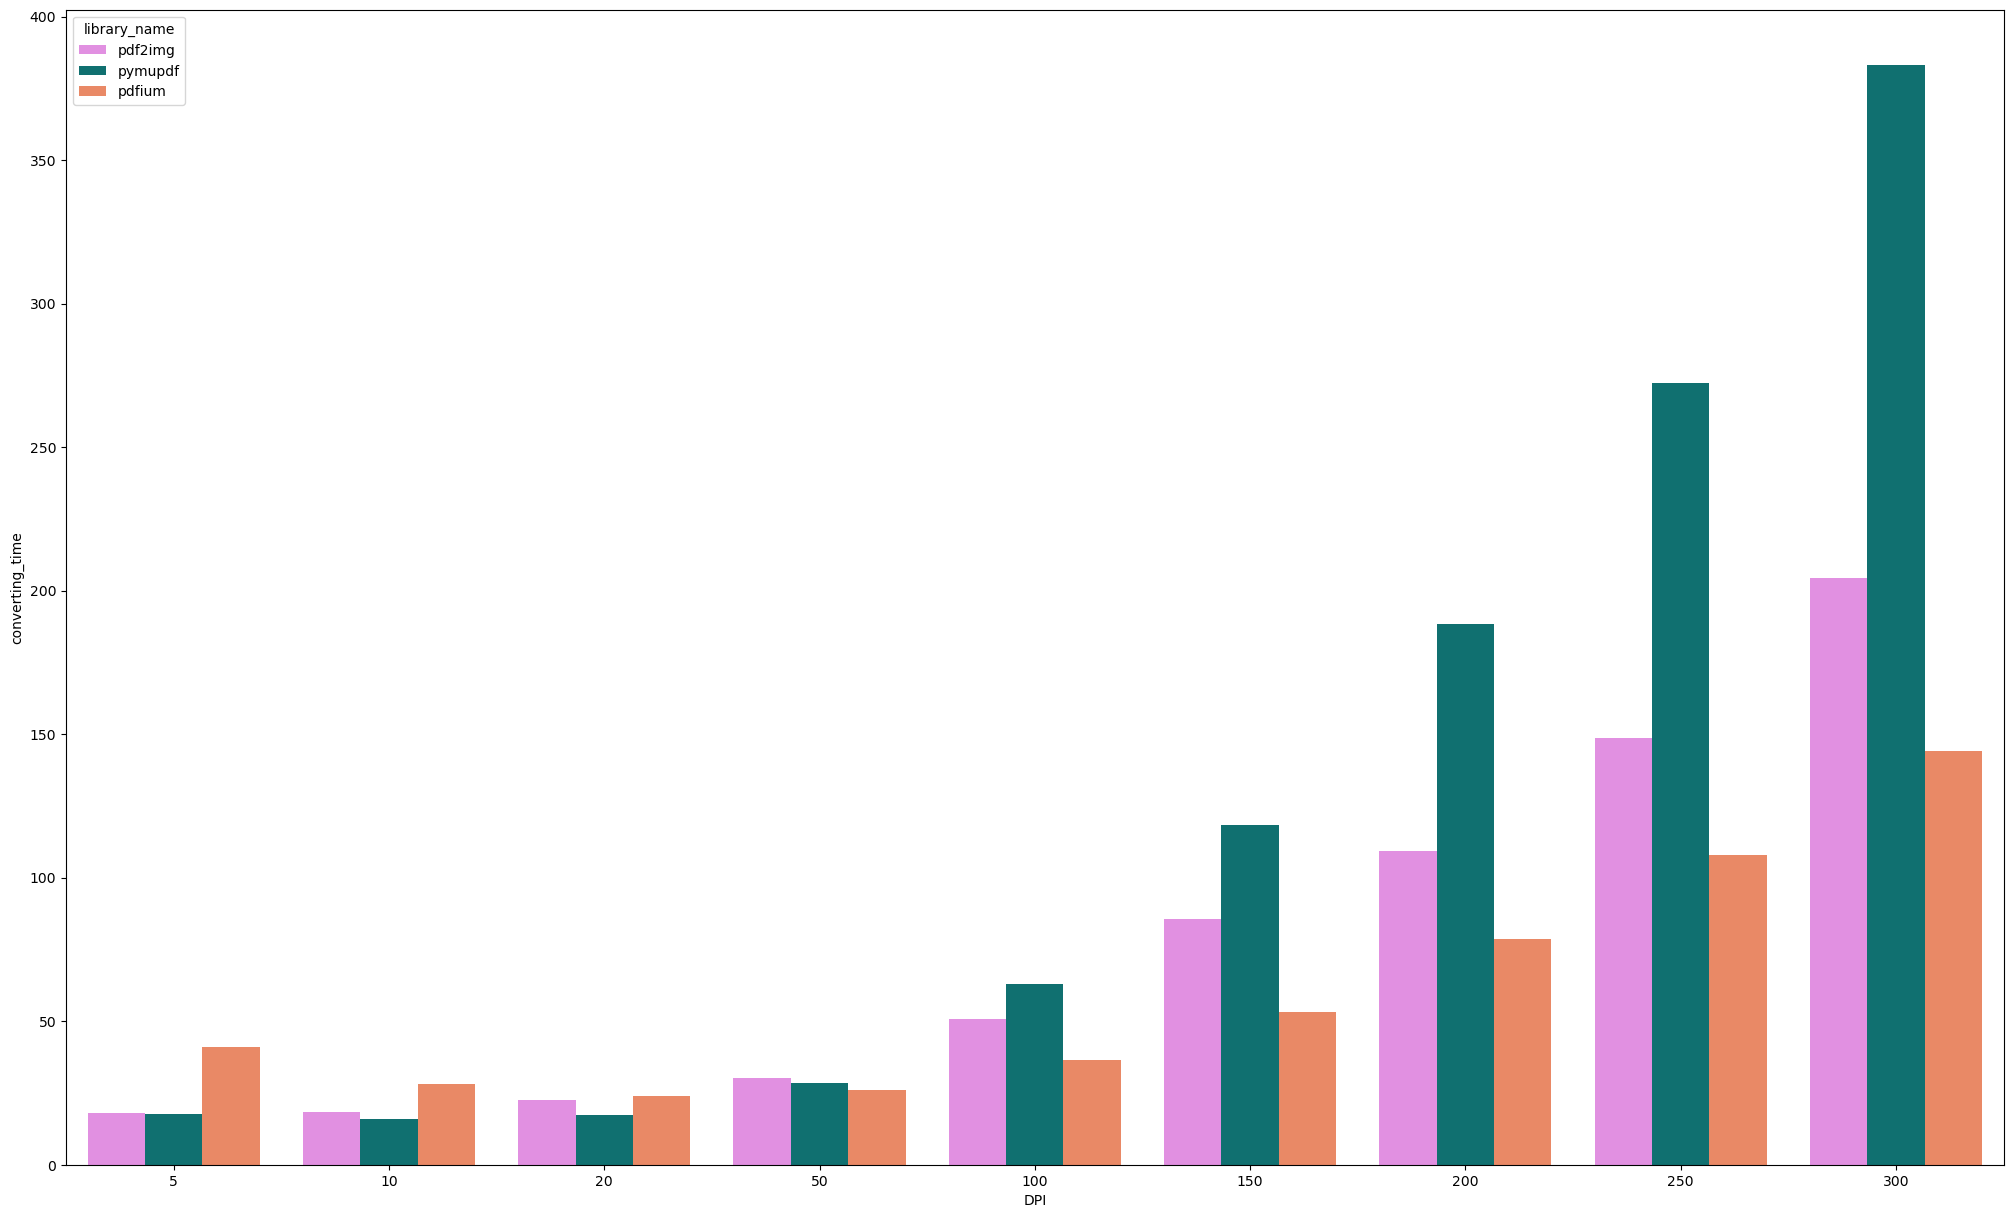

In [56]:
plt.figure(figsize=(25,15))
sns.barplot(data=df, x='dpi', y='converting_time', hue='library_name', palette=['violet', 'teal', 'coral'])
plt.xlabel("DPI")
plt.show()

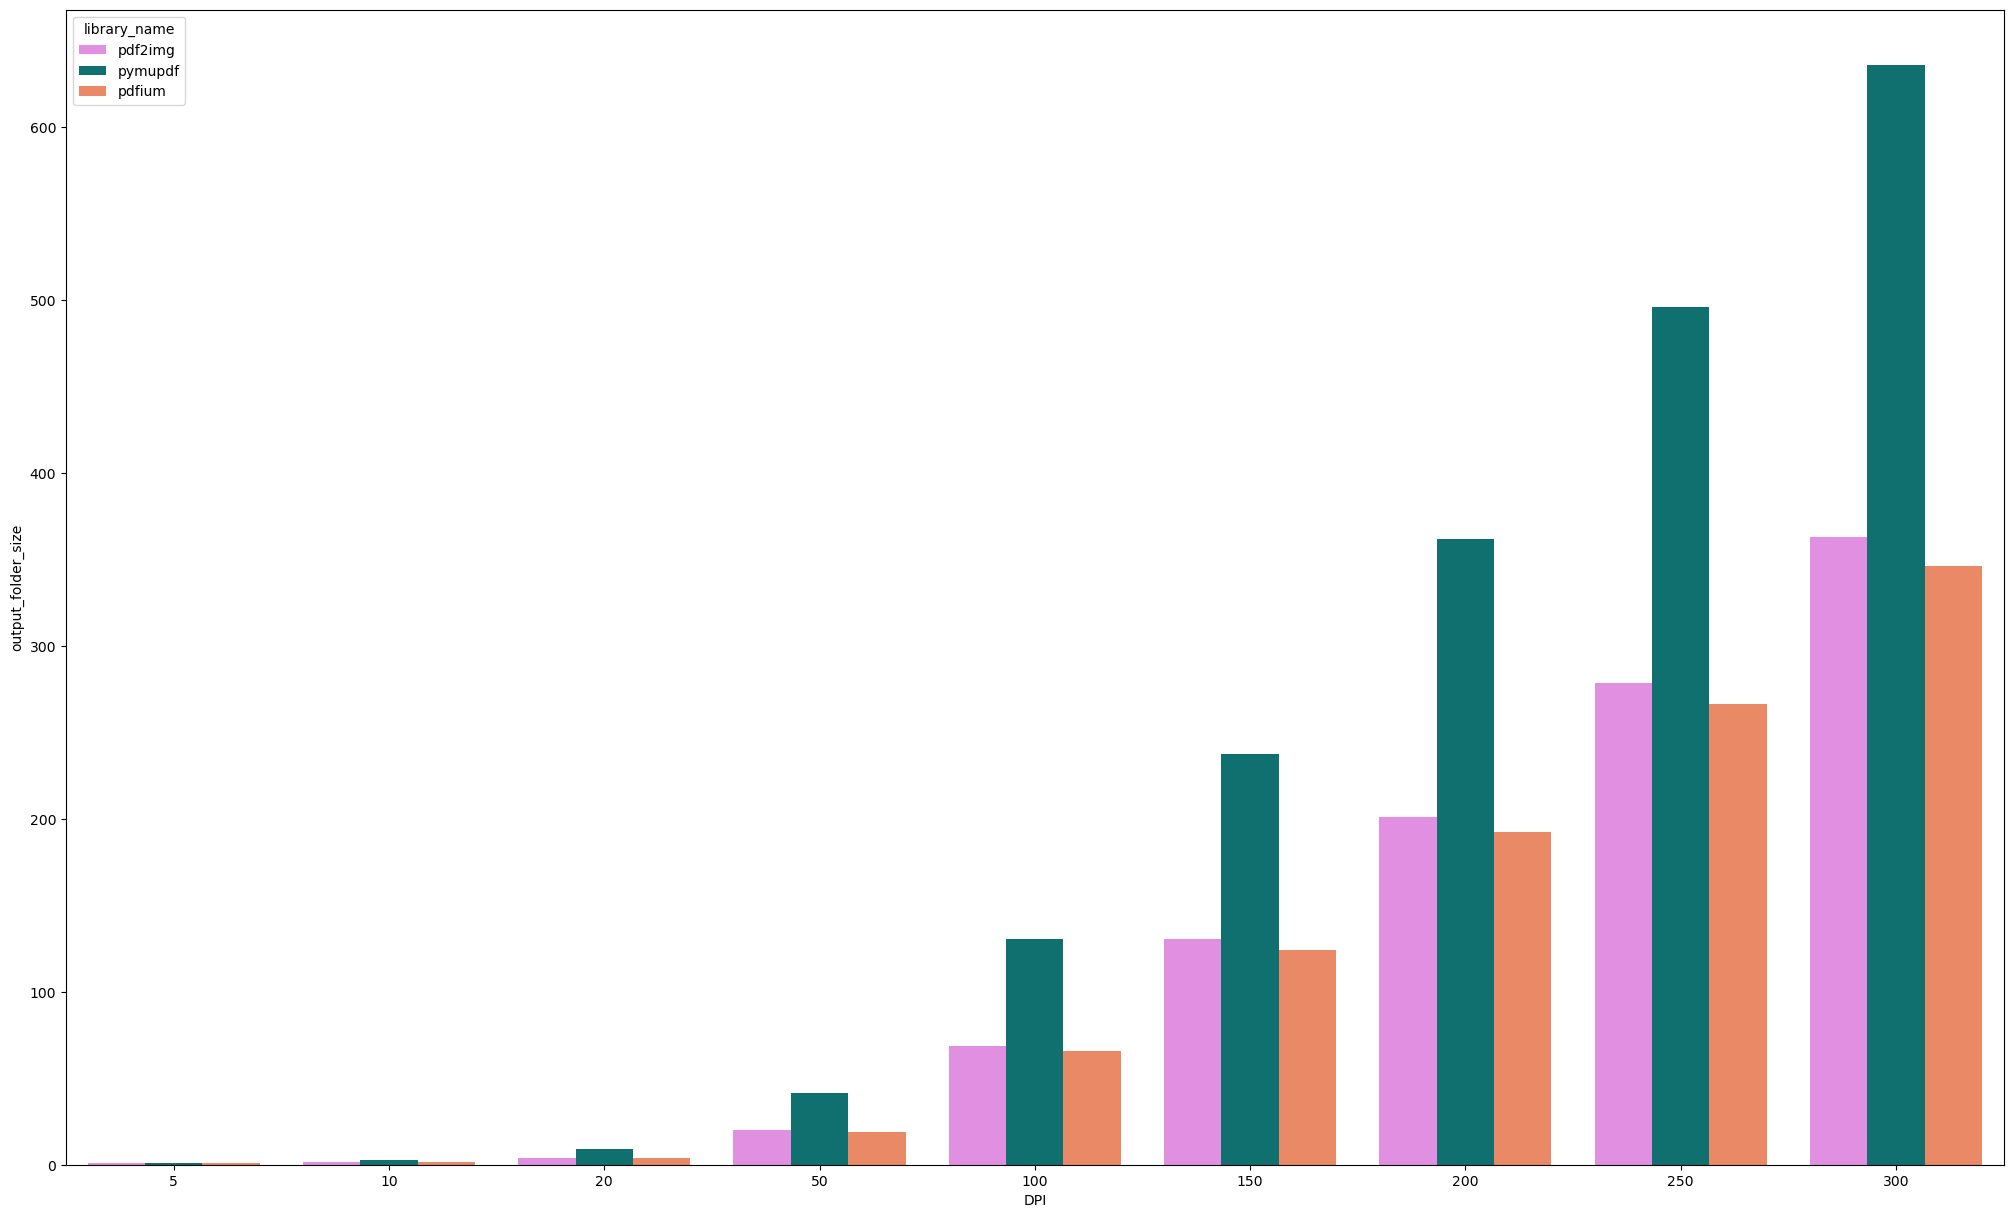

In [55]:
plt.figure(figsize=(25,15))
sns.barplot(data=df, x='dpi', y='output_folder_size', hue='library_name', palette=['violet', 'teal', 'coral'])
plt.xlabel("DPI")
plt.show()

## Kesimpulan
Library `pdfium` memiliki kecepatan paling tinggi dan total ukuran file paling rendah daripada `pdf2img` dan `PyMuPDF`

In [109]:
import pathlib

r = pathlib.Path().resolve().parent

In [110]:
r.joinpath("output/csv/")

PosixPath('/Users/rasyidev/Documents/rasyidevcode/print-cost/output/csv')